# TP 2 : La segmentation bayésienne d'image

### Import, constante and some general function

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
import codes.utils as utils
import cv2 as cv
import sklearn.tree
import numpy as np
from sklearn.cluster import KMeans 


ITER = 500

In [2]:
# Get name of  all images
PATH = os.getcwd()+'/images/'
images = [file for file in os.listdir(PATH) if file.endswith('.bmp')]

# II - Modèle des couples indépendants
### 3 - Ecriture de la fonction estim_param_EM_indep(iter, Y, p1, p2, m1, sig1, m2, sig2), qui estime les paramètres p1, p2, m1, sig1, m2, sig2 par l'algorithme EM (Expectation Maximization)
![alt text](algo_EM.png "Title")

In [3]:
def estim_param_EM_indep(itera, Y, p1, p2, m1, sig1, m2, sig2):
    for index in range(itera):
        num = p1 * norm.pdf(Y, m1, sig1**(1/2))

        P1 = num / (num + p2 * norm.pdf(Y, m2, sig2**(1/2)))
        P2 = 1 - P1
        
        p1 = np.sum(P1)/len(P1)
        
        p2 = 1 - p1
        
        m1 = np.sum(Y * P1)/np.sum(P1)
        m2 = np.sum(Y * P2)/np.sum(P2)

        sig1 = np.sum((Y - m1)**2 * P1) / np.sum(P1)
        sig2 = np.sum((Y - m2)**2 * P2) / np.sum(P2)
    
    return p1, p2, m1, m2, sig1, sig2

### 4 - Ecriture du script Segmentation_image_indep.py : 
    - acquiert, bruite et estime les paramètres sur la version bruitée puis segmente une image selon le modèle indépendant. 
    - calcul le taux d’erreur entre l’image segmentée et l’image réelle 
    - Affiche l'image réélle, l’image bruitée et l’image segmentée.

In [4]:
def set_param_estim(Y):
    
    kmeans = KMeans(n_clusters = 2, random_state = 0).fit(Y.reshape(-1,1))
    
    p1 = np.sum(kmeans.labels_)/len(kmeans.labels_)
    p2 = 1 - p1
    
    m1 = np.sum(np.multiply(Y, kmeans.labels_))/np.sum(kmeans.labels_)
    m2 = np.sum(np.multiply(Y, (1 - kmeans.labels_)))/np.sum((1 - kmeans.labels_))

    sig1 = np.sum(np.multiply((Y - m1)**2, kmeans.labels_)) / np.sum(kmeans.labels_)
    sig2 = np.sum(np.multiply((Y - m2)**2, (1 - kmeans.labels_)))/np.sum((1 - kmeans.labels_))
    
    return p1, p2, m1, sig1, m2, sig2

def get_classes(X):
        counts, _ = np.histogram(X, bins=int(X.max()+1), range=(0,int(X.max())))
        return np.nonzero(counts)[0]

def display_img(img, cfg=None, rate_err=None, fig_nbr=''):
    fig,ax = plt.subplots(1,3, figsize=(15,5))
    img_info = ['Image originale','Image bruitée','Image segmentée']
    for index in range(3):
        ax[index].imshow(img[index], cmap="gray")
        #ax[i].set_title("Bruit : {0} \n $\mu$1 = {1}, $\sigma$ 1= {2} / $\mu$2 = {3}, $\sigma$2 = {4}\nErreur de ségmentation : {5:.2f}%".format(i+1,m1[i],sig1[i],m2[i],sig2[i],erreur_l[i]*100))
        # lambda
        #title = lambda m1, m2, sig1, sig2, rate_err : f'Bruit : \n $\mu$1 = {m1}, $\sigma$ 1= {sig1} / $\mu$2 = {m2}, $\sigma$2 = {sig2}\nErreur de ségmentation : {(rate_err*100):.2f}%'
        if index == 2 :
            ax[index].set_title(f'{img_info[index]}\n Bruit : {fig_nbr}\n $\mu$1 = {cfg[0]}, $\sigma$ 1= {cfg[2]} / $\mu$2 = {cfg[1]}, $\sigma$2 = {cfg[2]}\nErreur de ségmentation : {(rate_err*100):.2f}%')
        else:
            ax[index].set_title(f'{img_info[index]}\n Bruit : {fig_nbr}\n $\mu$1 = {cfg[0]}, $\sigma$ 1= {cfg[2]} / $\mu$2 = {cfg[1]}, $\sigma$2 = {cfg[2]}')
            

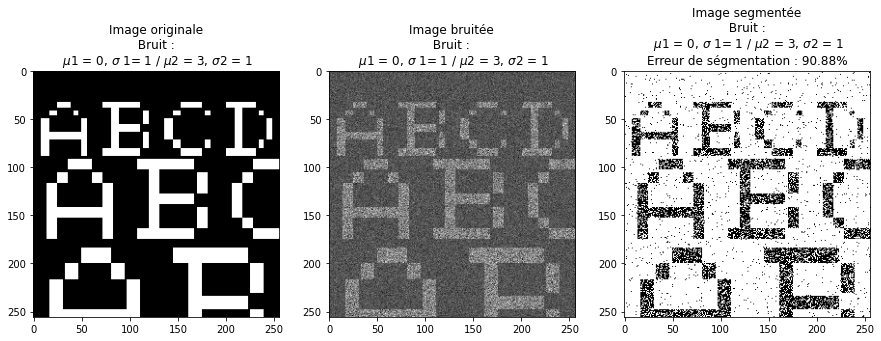

In [5]:
def Segmentation_image_indep(itera, img, m1, sig1, m2, sig2):
    
    original_img = cv.cvtColor(cv.imread(img),cv.COLOR_BGR2GRAY)

    img_line = utils.line_transform_img(original_img)
    
    cl1, cl2 = get_classes(img_line)
    
    Y = utils.bruit_gauss2(img_line, cl1, cl2, m1, sig1, m2, sig2)
    
    p1, p2, m1, sig1, m2, sig2 = set_param_estim(Y)
            
    noisy_img = utils.transform_line_in_img(Y, 256)
    
    p1em, p2em, m1em, m2em, sig1em, sig2em = estim_param_EM_indep(itera, Y,  p1, p2, m1, sig1, m2, sig2)

    segm = utils.MAP_MPM2(Y, cl1, cl2, p1em, p2em, m1em, sig1em**(1/2), m2em,  sig2em**(1/2))
    segm_img = utils.transform_line_in_img(segm, 256)
    error_rate = utils.taux_erreur(img_line, segm)
    return error_rate, (original_img, noisy_img, segm_img)

# set for test
m1, m2, sig1, sig2 = (0, 3, 1, 2)

error_rate, original_noisy_segm_img = Segmentation_image_indep(ITER, PATH+images[3], m1, sig1, m2, sig2)

display_img(original_noisy_segm_img, (m1, m2, sig1, sig2), error_rate)


### 5 - Test de la méthode pour 3 images avec les 3 bruits du tableau  ci-dessous. Présenter les résultats (taux d’erreur et images segmentées).
Pour  le  test j'ai shoisi les images : alpha2, promenade2 et city2.

![alt text](tab_test_em.png "Title")

In [ ]:
# m1, m2, sig1, sig2
test_set = [(0, 3, 1, 2), (1, 1, 1, 5), (0, 1, 1, 1)]

# image : alpha2, promenade2 and city2
img_for_test = [images[3], images[0], images[1]]

for img in img_for_test:
    fig_nbr = 1
    for cfg in test_set :    
        error_rate, original_noisy_segm_img = Segmentation_image_indep(ITER, PATH+img, cfg[0], cfg[2], cfg[1], cfg[3])       
        display_img(original_noisy_segm_img, cfg, error_rate, fig_nbr)
        fig_nbr+=1